# Predicting Lung Cancer Mortality Rates in US Counties.

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

In [1]:
# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from scipy.stats import spearmanr

# Vis Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters


# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import sklearn.preprocessing
import statsmodels.api as sm

# Custom Module Imports
import wrangle
import explore
import model

## Project Goal
- My goal is to find key features of lung cancer mortality rate and use them to predict it with the least amount of error.

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

## Acquire and Prepare Data

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

- The function wrangle_df reads the data from a csv, saves it to a dataframe and prepares the data for exploration. It also scales the data to be used later in modeling.

In [2]:
# reading the csv, preparing the data, splitting the data, and scaling the data for modeling.
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.wrangle_df()

## Acquire and Prepare takeaways

- The dataset now has 3047 rows and 35 columns, and nulls have been imputed using the mean and a flat value.
- The train, validate, and test dataframes are a 60/20/20 split.
- The data was scaled using a MinMax Scaler

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

## Explore Data

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

### What are the correlations in the data?

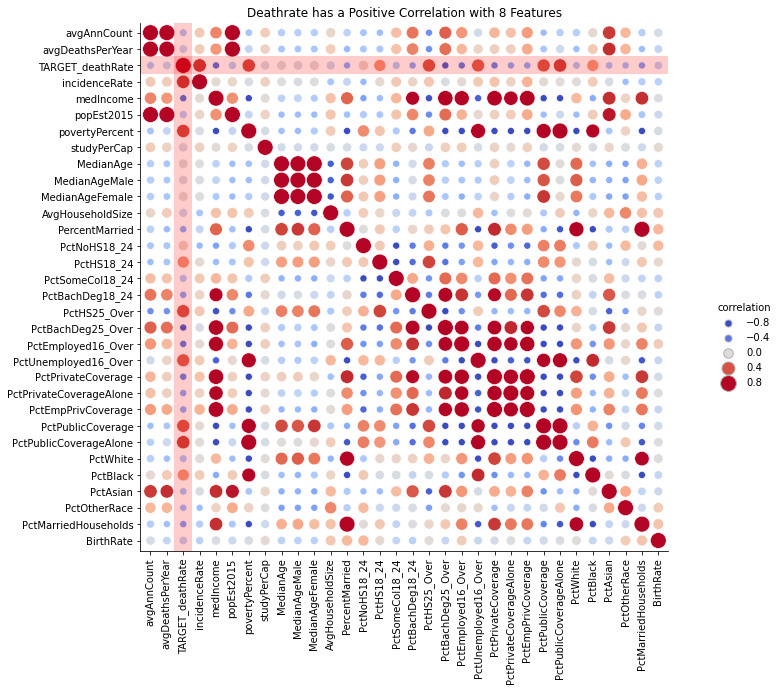

In [3]:
explore.corr_vis(train)

## Correlation Heatmap Takeaways
- Deathrate has a positive correlation with incidenceRate, povertyPercent, PctHS18_24, PctHS25_Over, PctUnemployed16_Over, PctPublicCoverage, PctPublicCoverageAlone, and PctBlack.

### Is there a relationship between Deathrate and Incidence Rate?

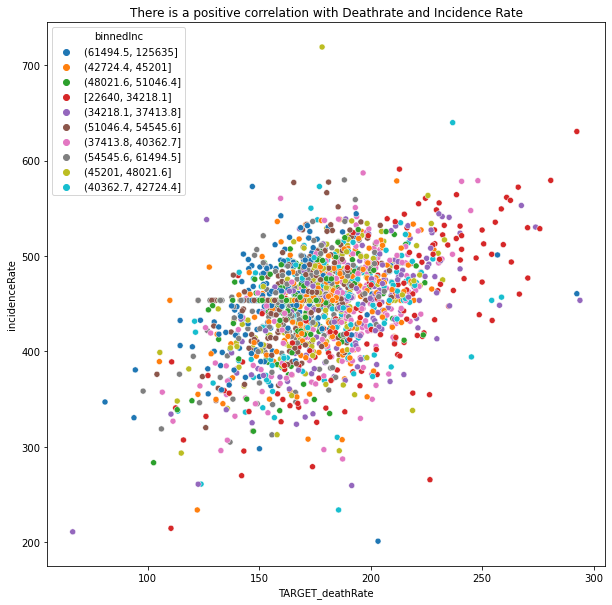

In [4]:
explore.vis_1(train)

## Scatterplot takeaways
- There appears to be a positive correlation between deathrate and incidence rate.

___

## Stats test for scatterplot (PearsonR)

$H_0$: There is no relationship between deathrate and incidence rate.

$H_a$: There is a relationship between deathrate and incidence rate.

Alpha = 0.05

In [5]:
explore.stats_1(train)

Correlation: 0.4430537506278721
P-value: 6.727324186023339e-83
We reject the null hypothesis that There is no relationship between the Deathrate and Incidence Rate.
There is a relationship between the Deathrate and Incidence Rate.


### Is Deathrate and Binned Income related?

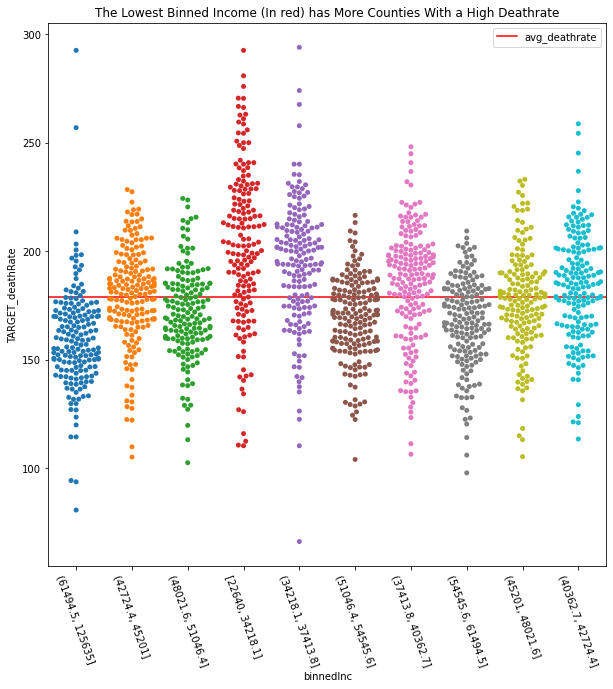

In [6]:
explore.vis_2(train)

## Swarmplot Takeaways
- The red binned income has more counties with extreme levels of deathrate.
- The blue binned income has a majority of their counties below the average deathrate.

### Is there a relationship between Deathrate and Poverty Percent?

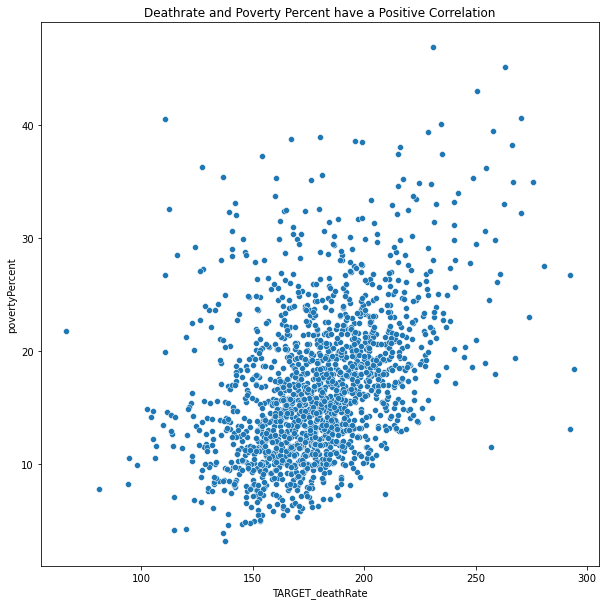

In [7]:
explore.vis_3(train)

## Scatterplot Takeaways
- There appears to be a relationship between deathrate and poverty percent.

___

## Stats test for scatterplot (PearsonR)

$H_0$: There is no relationship between deathrate and poverty percent.

$H_a$: There is a relationship between deathrate and poverty percent.

Alpha = 0.05

In [8]:
explore.stats_3(train)

Correlation: 0.41691234501658186
P-value: 1.1374787774622218e-72
We reject the null hypothesis that There is no relationship between the Deathrate and Poverty Percent.
There is a relationship between the Deathrate and Poverty Percent.


## Is there a relationship between Deathrate and Median Age?

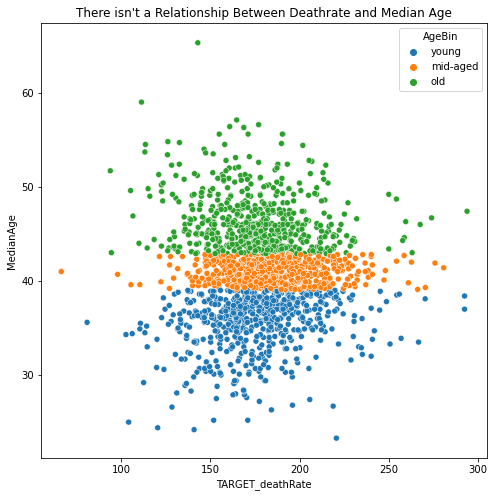

In [9]:
explore.vis_4(train)

## Scatterplot Takeaways
- Median age does not appear to have a relationship with deathrate.

___

## Stats test for scatterplot (PearsonR)

$H_0$: There is no relationship between deathrate and median age.

$H_a$: There is a relationship between deathrate and median age.

Alpha = 0.05

In [10]:
explore.stats_4(train)

Correlation: -0.006682942377748776
P-value: 0.782739789716502
We fail to reject the null hypothesis that There is no relationship between the Deathrate and Median Age.


## Does a specific age bin have affect the deathrate?

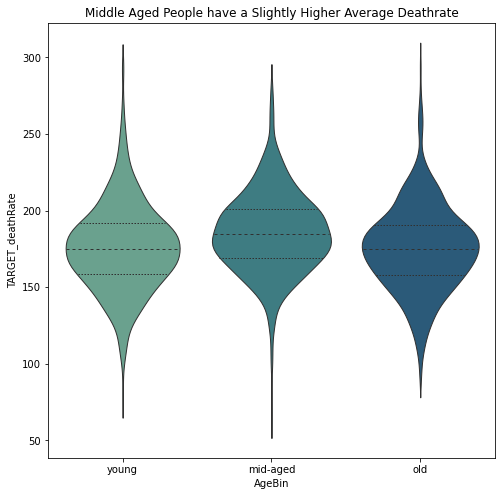

In [11]:
explore.vis_5(train)

## Violinplot Takeaways
- The Mid-Aged bin has a slightly higher average deathrate then young or old does.
- All age bins have a fairly similar target deathrate.

## How many people that died from cancer were diagnosed?

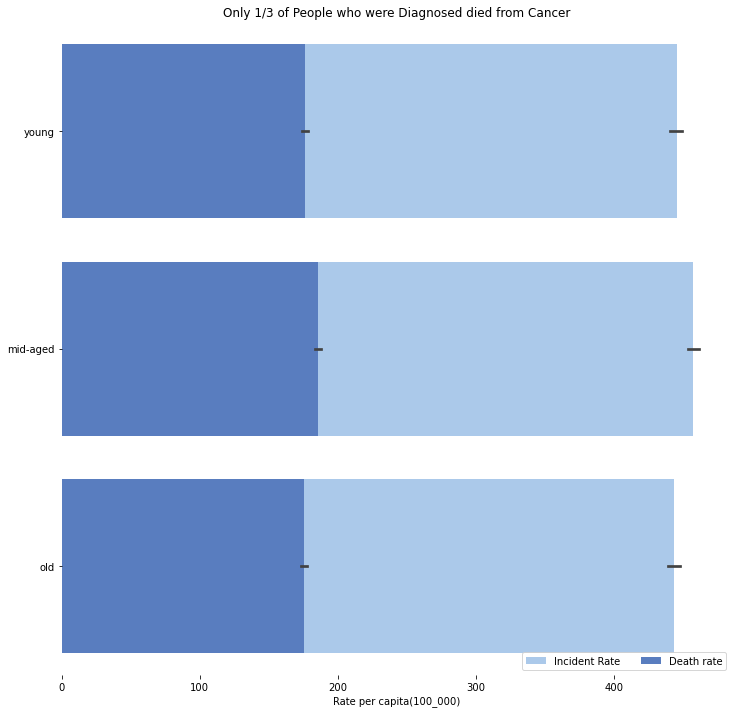

In [12]:
explore.vis_6(train)

## Barplot Takeaways
- Since incidence rate is how many are diagnosed and deathrate is how many have died. We can tell that only 1/3 of the people diagnosed actually died.

## Explore Takeaways
- Only 1/3 of the people diagnosed actually died.
- The Mid-Aged bin has a slightly higher average deathrate then young or old does.
- The red binned [22640, 34218.1] income has more counties with extreme levels of deathrate.
- The blue binned (61494.5, 125635] income has a majority of their counties below the average deathrate. 

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

## Model and Evaluate

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

### Define X and y train, val, and test datasets.

In [13]:
# Setting the features to be used in the models to a variable.
X_cols = ['incidenceRate', 'povertyPercent', 'PctHS25_Over',
       'PctBachDeg25_Over', 'PctPublicCoverageAlone', 'PctHS18_24', 'PctUnemployed16_Over',
         'PctPublicCoverage']

# Creating the X & y version of train, validate, and test with the scaled data
# where y is a series with just the target variable and X are all the features. 
X_train = train_scaled[X_cols]
y_train = train_scaled.TARGET_deathRate

X_validate = validate_scaled[X_cols]
y_validate = validate_scaled.TARGET_deathRate

X_test = test_scaled[X_cols]
y_test = test_scaled.TARGET_deathRate

# We need y_train, y_validate, and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

### Baseline RMSE
- Mean of the Death Rate was used to predict the RMSE value.
- Baseline RMSE: 27.83

In [14]:
model.baseline(y_train)

RMSE using Mean
Train/In-Sample:  27.83


## Evaluate Top 3 Models
### My Top 3 Models were:
- Lasso + Lars
- OLS using LinearRegression
- Polynomial Model

In [15]:
model.eval_models(y_train, y_validate, X_train, X_validate, X_test, y_test)

RMSE for Lasso + Lars
Training/In-Sample:  27.83 
Validation/Out-of-Sample:  27.42
R2 Value: 0.0
-----------------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  20.25 
Validation/Out-of-Sample:  18.96
R2 Value: 0.47
-----------------------------------------------
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  19.11 
Validation/Out-of-Sample:  19.14
R2 Value: 0.53


## Model Takeaways
- My Polynomial Model was my best with an RMSE value of 19.14 and a R2 value of 0.53 on the validate dataset.

## Testing the best Model (Polynomial Model)

In [16]:
model.test_model(y_test, X_train, X_test, y_train)

RMSE for Polynomial Model, degrees=2
Test/Out-of-Sample:  20.49
R2 Value: 0.46


<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

## Conclusions
- Only 1/3 of the people diagnosed actually died.
- The Mid-Aged bin has a slightly higher average deathrate then young or old does.
- The red binned [22640, 34218.1] income has more counties with extreme levels of deathrate.
- The blue binned (61494.5, 125635] income has a majority of their counties below the average deathrate.
- Our RMSE value for our test dataset beat our baseline by 26%.

### In order to potentially reduce the deathrate in certain counties, we need to find a way to incentivise people in those lower income ranges to get checked more often. This can possibly be done through a public program of some sort. We can also spread more awareness to get checked in the first place. 

<hr style="border-top:10px groove PaleTurquoise; margin-top: 2px; margin-bottom: 2px">

## Next Steps
- If I had more time with the data I would implement clustering to see if I can impove the models performance.
- I would also pull more of the raw data to see if I could feature engineer more columns.